In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
path = os.getenv("store_data")
store = pd.HDFStore(path = path)

In [71]:
plt.style.use("ggplot")

In [5]:
df = store["health_data"];df.head()

,Age,BMI,Exercise_Frequency,Diet_Quality,Sleep_Hours,Smoking_Status,Alcohol_Consumption,Health_Score
0,45.960570,31.996777,5,55.403270,7.300359,0,2.834707,70.542122
1,38.340828,29.623168,6,41.838357,7.012419,1,7.199517,57.244637
2,47.772262,25.298152,5,76.904948,6.028641,1,4.097944,96.333722
3,58.276358,21.765316,2,49.756767,5.802714,1,3.649377,61.321783
4,37.190160,28.491117,2,44.218737,7.912548,0,2.839795,67.175894


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  1000 non-null   float64
 1   BMI                  1000 non-null   float64
 2   Exercise_Frequency   1000 non-null   int64  
 3   Diet_Quality         1000 non-null   float64
 4   Sleep_Hours          1000 non-null   float64
 5   Smoking_Status       1000 non-null   int64  
 6   Alcohol_Consumption  1000 non-null   float64
 7   Health_Score         1000 non-null   float64
dtypes: float64(6), int64(2)
memory usage: 70.3 KB


In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1000.0,40.231985,11.750591,1.104792,32.228916,40.303607,47.775327,86.232778
BMI,1000.0,25.354181,4.987272,10.298057,21.968792,25.315386,28.644411,40.965538
Exercise_Frequency,1000.0,2.888000,1.995354,0.000000,1.000000,3.000000,5.000000,6.000000
Diet_Quality,1000.0,69.952977,14.972061,19.907497,59.945481,69.975151,80.527839,110.265186
Sleep_Hours,1000.0,6.973135,1.517218,2.431107,5.903351,6.990847,8.054595,11.638962
Smoking_Status,1000.0,0.499000,0.500249,0.000000,0.000000,0.000000,1.000000,1.000000
Alcohol_Consumption,1000.0,3.079377,2.084564,-3.592506,1.644111,3.064261,4.489293,11.105100
Health_Score,1000.0,85.479947,13.633845,29.106017,76.430819,87.498996,99.762644,100.000000


In [11]:
df["Alcohol_Consumption"] = list(map(lambda x: 0 if x < 0 else x, df["Alcohol_Consumption"]))
df["Age"] = df["Age"].astype(dtype = "int")

In [13]:
df["Alcohol_Consumption"].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
Alcohol_Consumption,1000.0,3.141149,1.966586,0.0,1.644111,3.064261,4.489293,11.1051


In [171]:
x = df.drop("Health_Score", axis = 1)
y = df["Health_Score"]

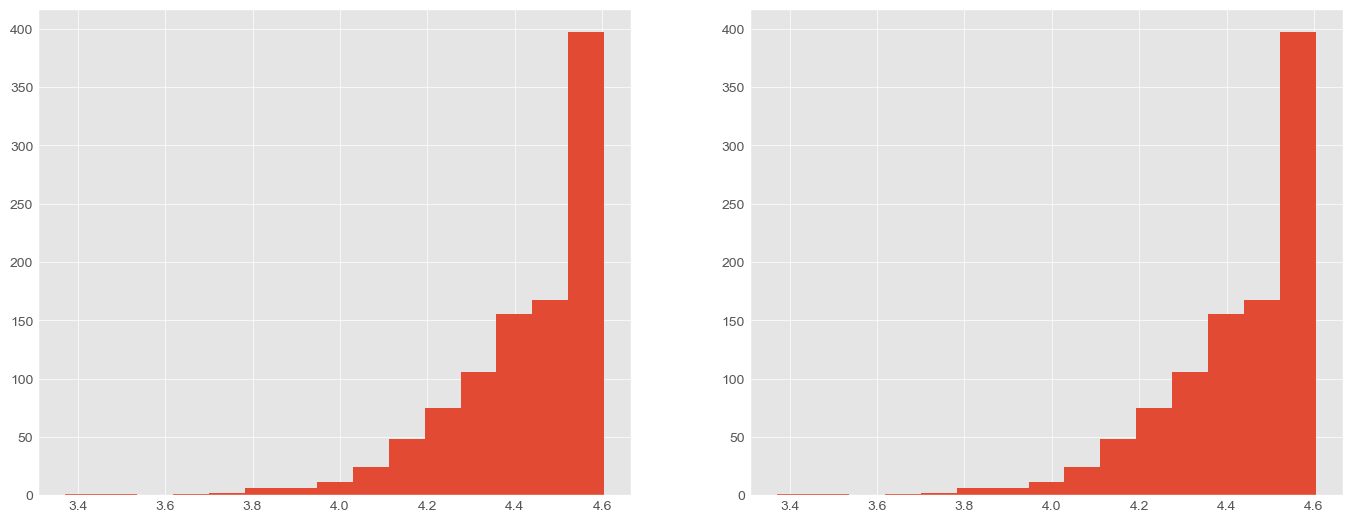

In [173]:
bins = np.histogram_bin_edges(y, bins = 20)
y_log = np.log(df["Health_Score"])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 6))
ax1.hist(x = y, bins = 15)
ax2.hist(x = y_log, bins = 15)
plt.show()

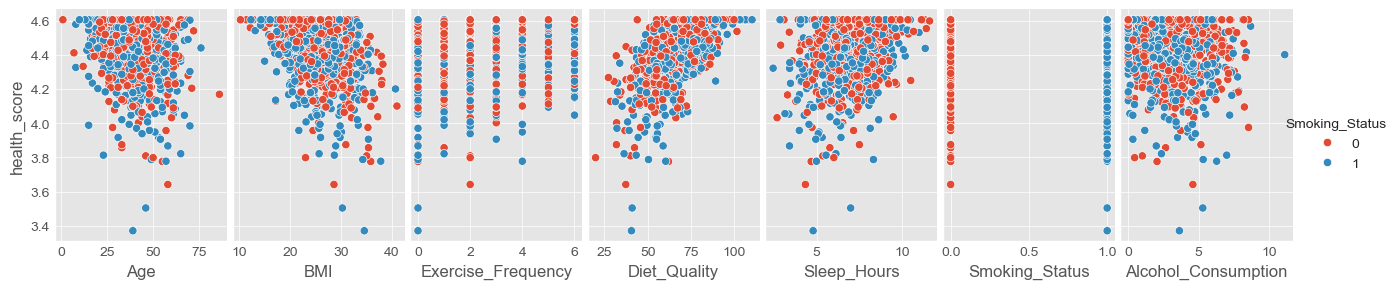

In [232]:
sns.pairplot(data = x.assign(health_score = y), x_vars = x.columns, y_vars = "health_score", hue = "Smoking_Status")
plt.gcf().set_size_inches(14, 3)

# feature_selection

In [208]:
from sklearn.feature_selection import mutual_info_regression

mutual_info = mutual_info_regression(X=x, y=y_log)
pd.DataFrame(data = mutual_info.reshape(-1, 1), index = x.columns, columns = ["mutual_info_scores"]).sort_values(by = "mutual_info_scores", ascending = False)

,mutual_info_scores
Diet_Quality,0.318953
BMI,0.120491
Sleep_Hours,0.077155
Alcohol_Consumption,0.059242
Age,0.039358
Exercise_Frequency,0.023156
Smoking_Status,0.000000


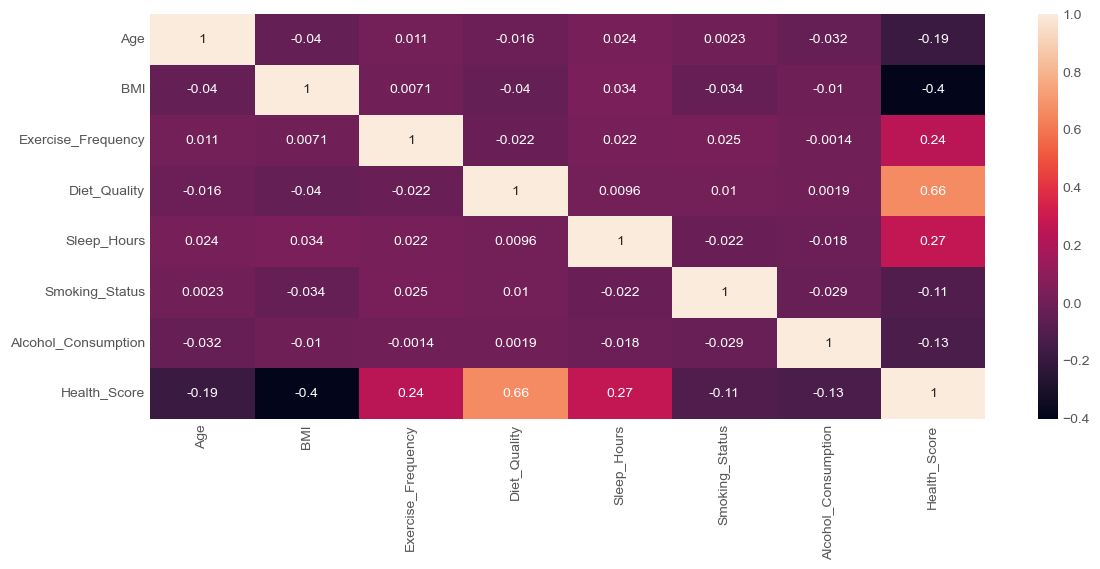

In [226]:
sns.heatmap(data = x.assign(Health_Score = y_log).corr(), annot=True)
plt.gcf().set_size_inches(12, 5)

In [290]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector
from sklearn.neighbors import KNeighborsRegressor

selector = ExhaustiveFeatureSelector(
    estimator=KNeighborsRegressor(n_neighbors = 10),
    min_features = 1, 
    max_features = len(x.columns),
    scoring= "neg_mean_squared_error",
    cv = 5,
    n_jobs= -1,
)
selector.fit(x, y_log)

Features: 127/127

ExhaustiveFeatureSelector(estimator=KNeighborsRegressor(n_neighbors=10),
                          feature_groups=[[0], [1], [2], [3], [4], [5], [6]],
                          max_features=7, n_jobs=-1,
                          scoring='neg_mean_squared_error')

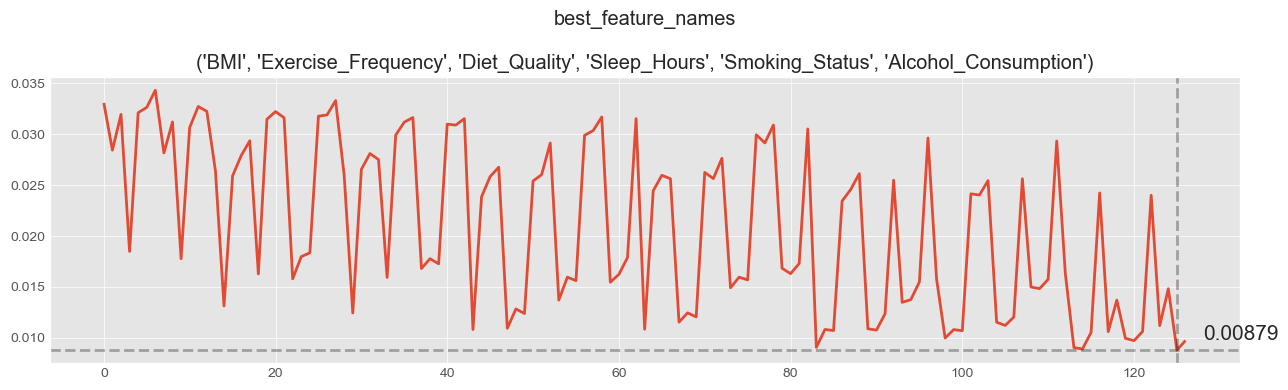

In [426]:
pd.Series({item: -1 * selector.subsets_[item]["avg_score"] for item in range(127)}).plot.line()
plt.axhline(y = -1 * selector.best_score_, ls = "--", alpha = 0.3)
plt.axvline(x = 125, ls = "--", alpha = 0.3)
plt.gcf().set_size_inches(13, 4)
plt.text(x = 125 + 3, y = -1 * selector.best_score_ + 0.001, s = f"{-1 * selector.best_score_:.5f}", size = 15)
plt.title(f"best_feature_names\n\n{selector.best_feature_names_}")
plt.tight_layout()

# Model

In [ ]:
x = x.iloc[:, [*selector.best_idx_]]

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=365)

scaler = StandardScaler()
scaler.fit(x_train)
scaler.transform(x_train)
scaler.transform(x_test)

# GridSearchCV

In [465]:
pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("model", KNeighborsRegressor())
    ]
)

params = {
    "model__n_neighbors": list(range(1, 20))
}

estimator = GridSearchCV(
    estimator = pipe,
    param_grid=params,
    cv = KFold(n_splits=10, shuffle=True, random_state = 365),
    scoring = "neg_mean_squared_error",
    n_jobs= -1
)
estimator.fit(x_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=365, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', KNeighborsRegressor())]),
             n_jobs=-1,
             param_grid={'model__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                11, 12, 13, 14, 15, 16, 17, 18,
                                                19]},
             scoring='neg_mean_squared_error')

In [519]:
cv_results = estimator.cv_results_
test_scores = pd.DataFrame({fold: cv_results[f"split{fold}_test_score"] for fold in range(10)}, index = list(range(1, 20))).stack().reset_index()
test_scores.columns = ["n", "k", "-mse"]
test_scores["mse"] = -1 * test_scores["-mse"]
means = test_scores.groupby(by = "n").mean().drop("k", axis = 1)

In [521]:
best_n, best_mse = means["mse"].idxmin(), means["mse"].min()

In [525]:
best_n, best_mse

(9, 0.009005331581990034)

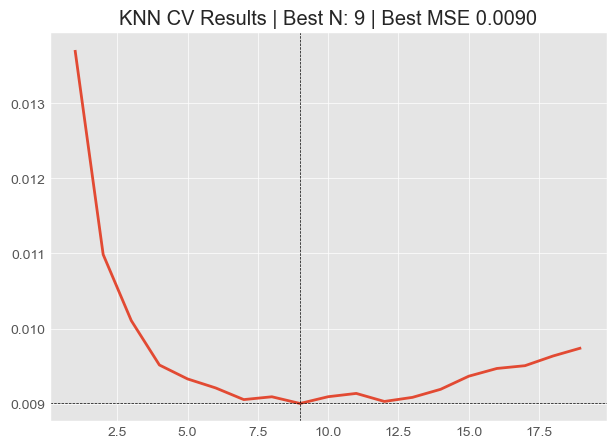

In [543]:
pd.Series(-1 * estimator.cv_results_["mean_test_score"], index = list(range(1, 20))).plot.line()
plt.axhline(y = best_mse, lw = 0.5, ls = "--")
plt.axvline(x = best_n, lw = 0.5, ls = "--")
plt.title(f"KNN CV Results | Best N: {best_n} | Best MSE {best_mse:.4f}");

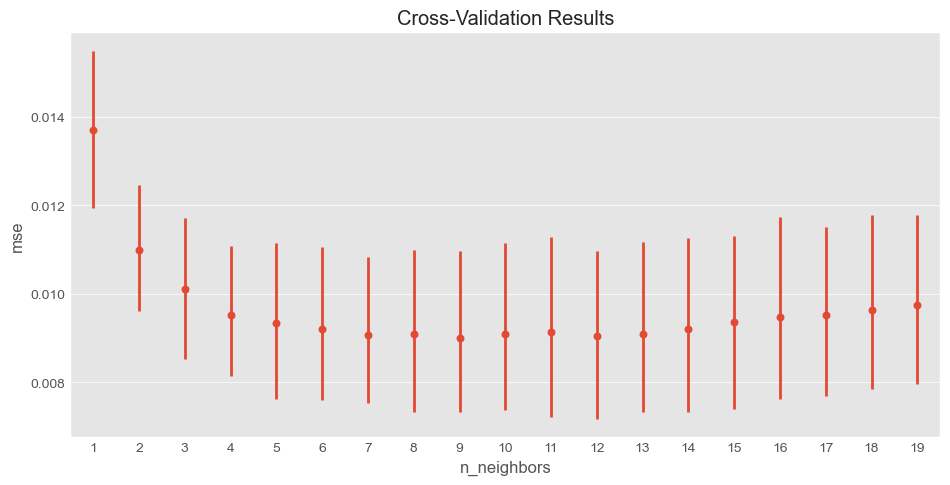

In [573]:
sns.pointplot(x = "n", y = "mse", data = test_scores, markersize = 3, linestyle='none', err_kws={'linewidth': 2})
plt.gcf().set_size_inches(10, 5)
plt.title("Cross-Validation Results")
plt.xlabel("n_neighbors");

# After Tuning

In [584]:
from sklearn.model_selection import cross_val_predict

pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("model", KNeighborsRegressor(n_neighbors=best_n))
    ]
)


y_pred = cross_val_predict(
    estimator=pipe,
    X=x,
    y=y,
    cv = 10,
    n_jobs = -1
)

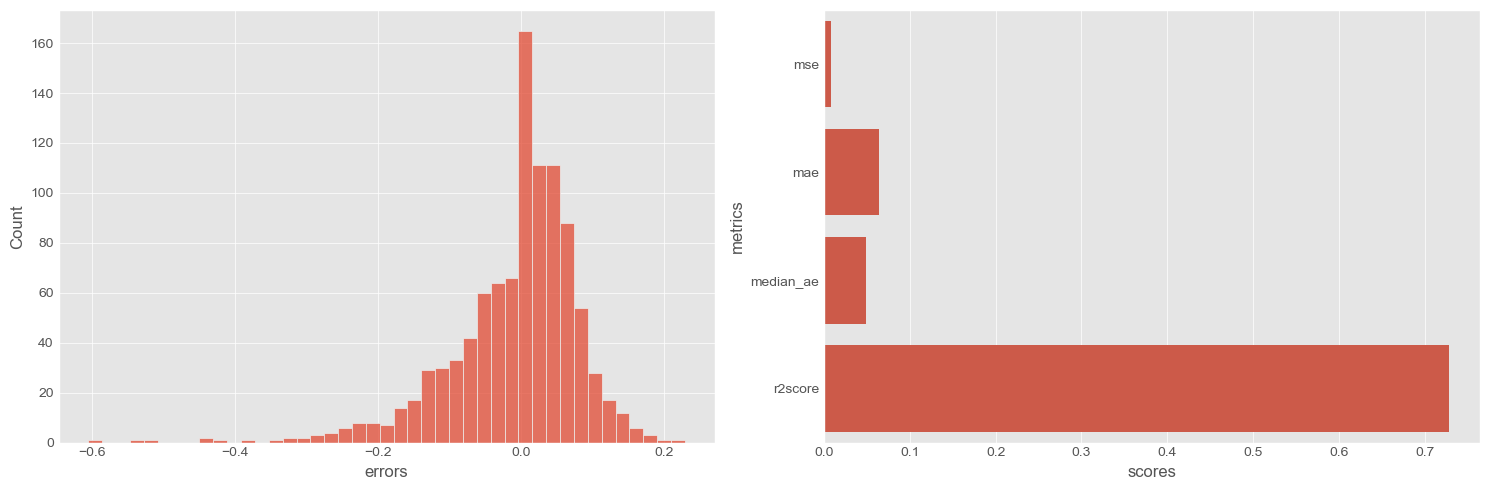

In [618]:
from sklearn.metrics import (
mean_squared_error,
mean_absolute_error,
median_absolute_error,
r2_score
)
erros = (y-y_pred).rename("errors")

scores = {
    "mse": mean_squared_error(y, y_pred),
    "mae": mean_absolute_error(y, y_pred),
    "median_ae": median_absolute_error(y, y_pred),
    "r2score": r2_score(y, y_pred)
}


fig, axes = plt.subplots(ncols=2, figsize = (15, 5))
sns.histplot(erros, ax = axes[0])
sns.barplot(data = pd.Series(data = scores).to_frame().reset_index(), orient = "h", y = "index", x = 0)
axes[1].set_ylabel("metrics")
axes[1].set_xlabel("scores")
plt.tight_layout()

In [634]:
pd.DataFrame(data = scores.items(), columns = ["metrics", "scores"]).set_index("metrics").T

metrics,mse,mae,median_ae,r2score
scores,0.008566,0.064573,0.049232,0.728101


In [654]:
model = KNeighborsRegressor(n_neighbors=best_n)
model.fit(scale(x_train), y_train)
y_pred_test = model.predict(scale(x_test))
print(f"r2_score: {r2_score(y_test, y_pred_test):.4f}")

r2_score: 0.7310
